## Настройка окружения

In [3]:
!nvidia-smi

Sat Nov 16 08:59:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Установка YOLO11

In [5]:
!pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.5/112.6 GB disk)


## Тюнинг YOLO11 на своем датасете

In [6]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="iFZGaJVqJ8m7sjJioKym")
project = rf.workspace("razmetka-dj4rc").project("tula")
version = project.version(2)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to tula-2 in yolov11:: 100%|██████████| 33872/33872 [00:06<00:00, 5040.23it/s]


## Обучение

In [9]:
!cd {HOME}

!yolo task=detect mode=train model=yolo11m.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

100% 38.8M/38.8M [00:00<00:00, 357MB/s]
Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/tula-2/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show

In [10]:
!ls {HOME}/runs/detect/train/

args.yaml  weights


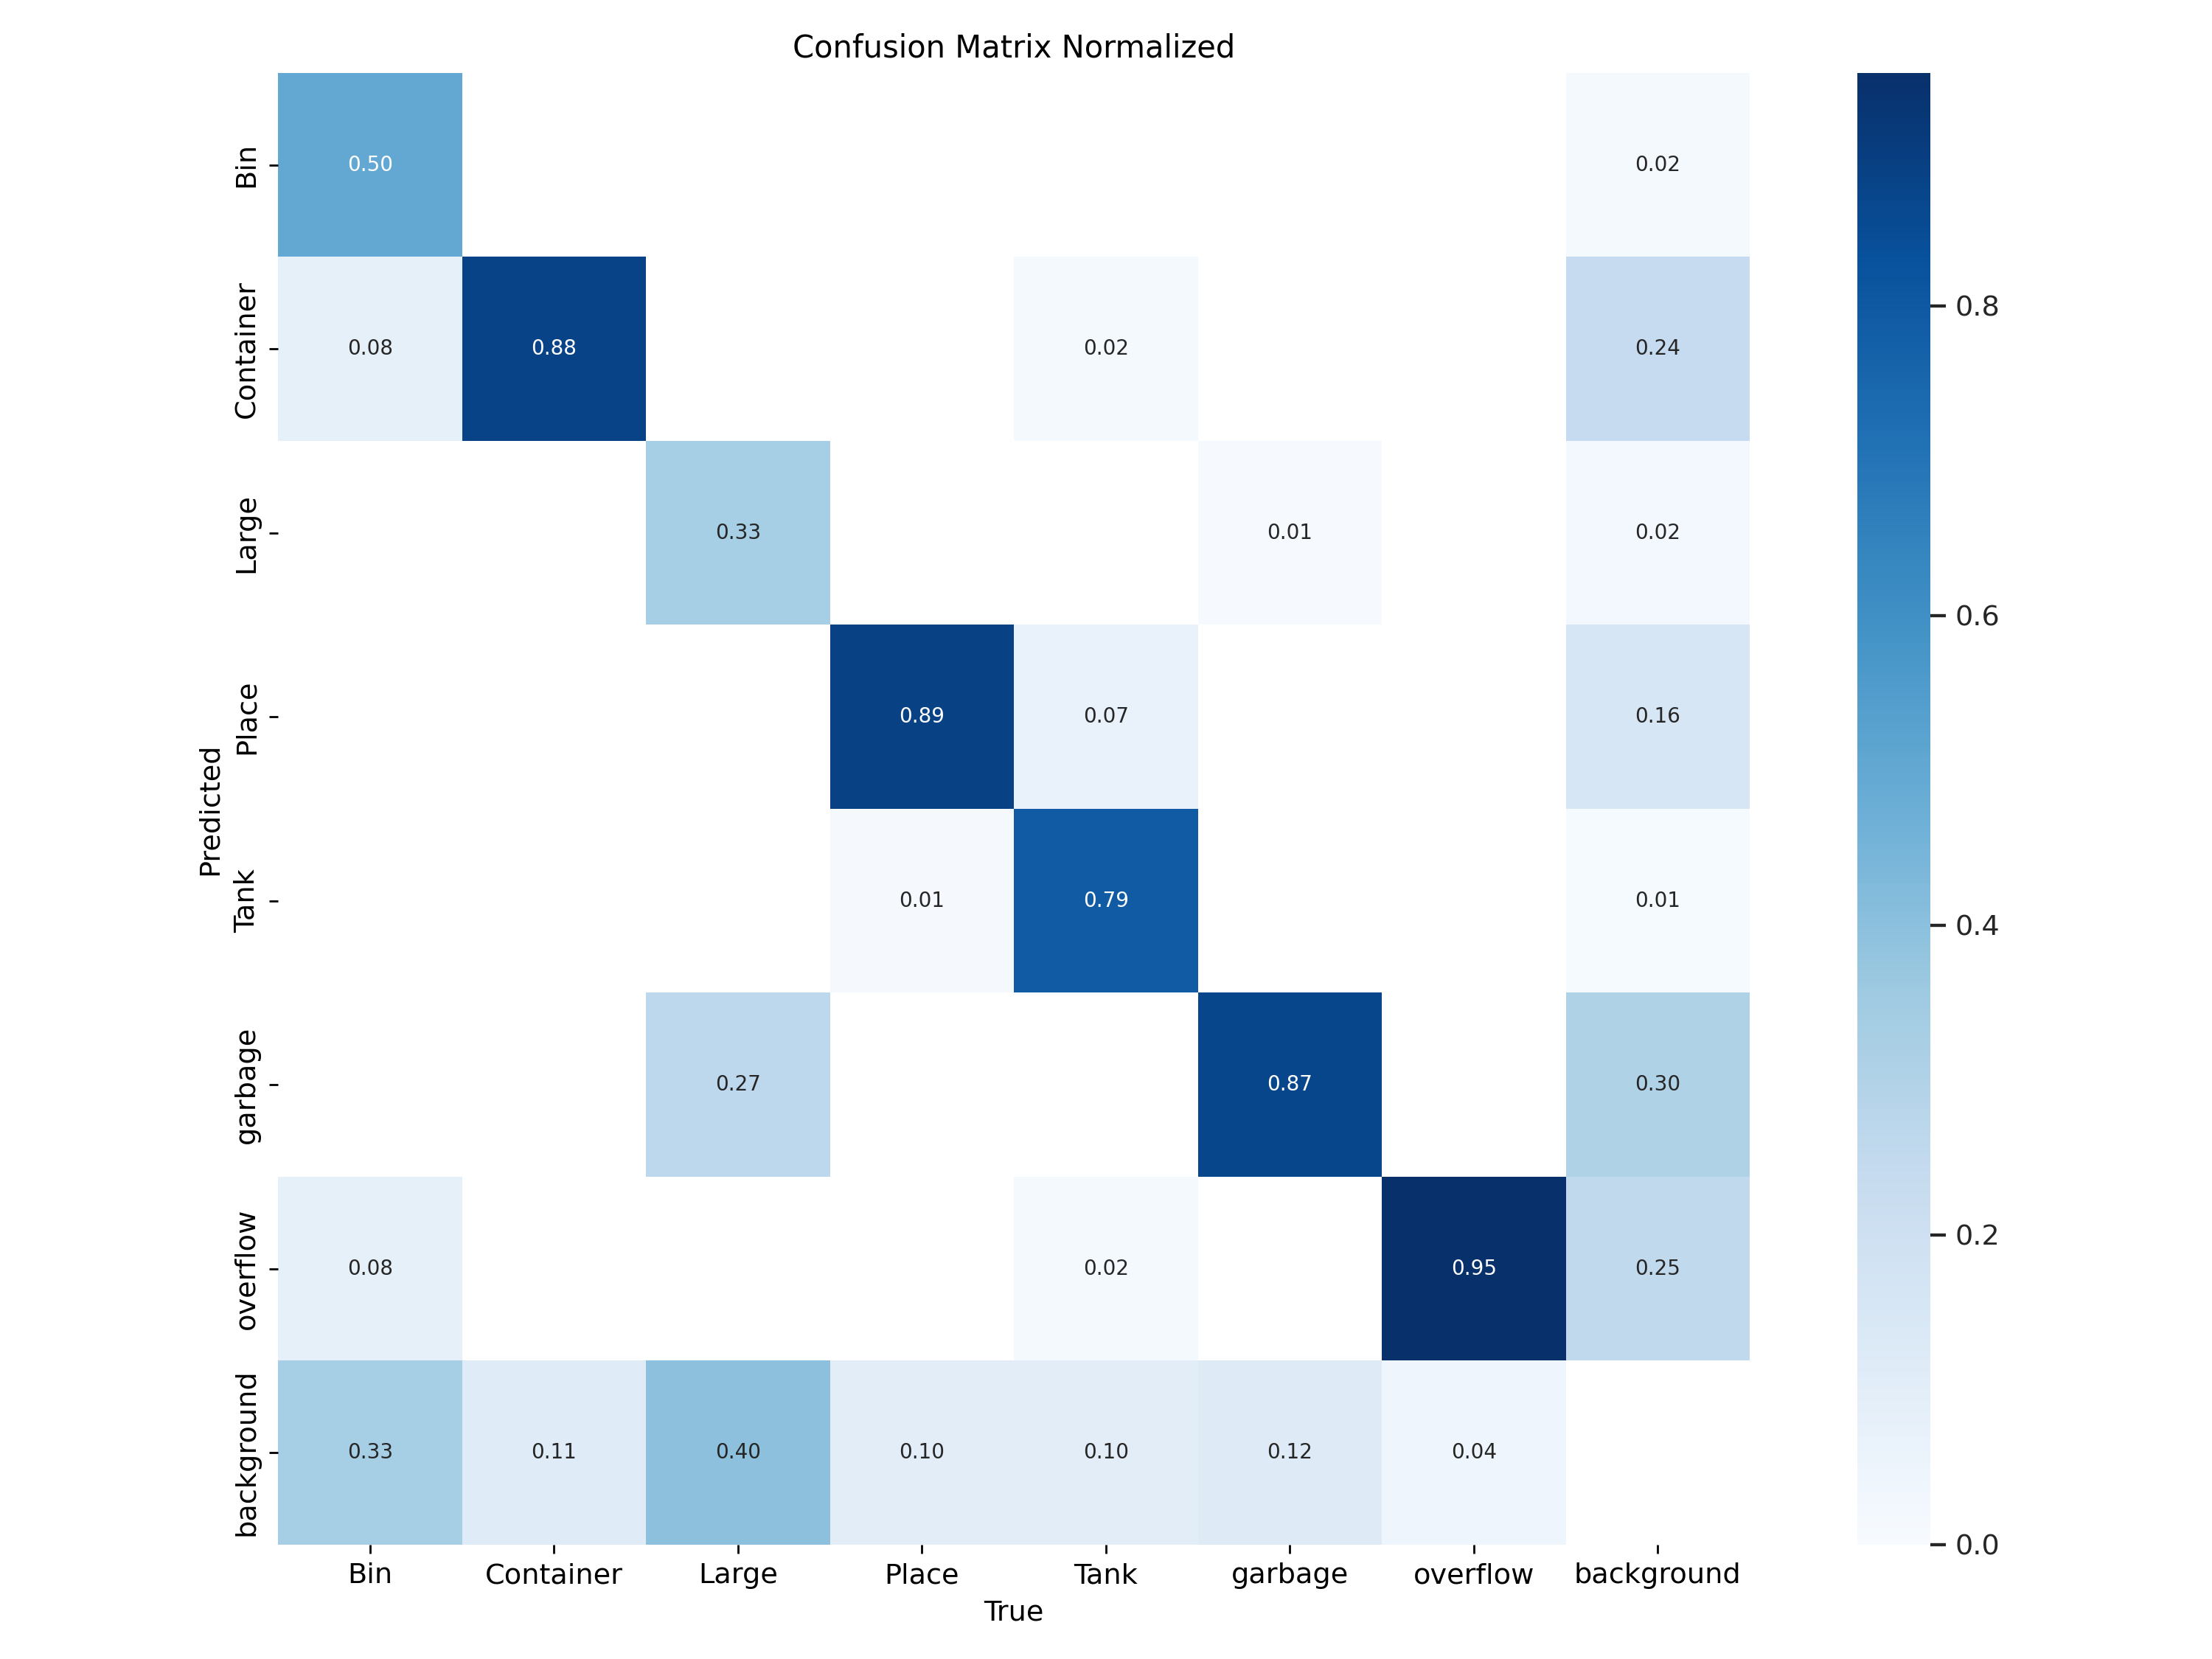

In [13]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/confusion_matrix_normalized.png', width=600)

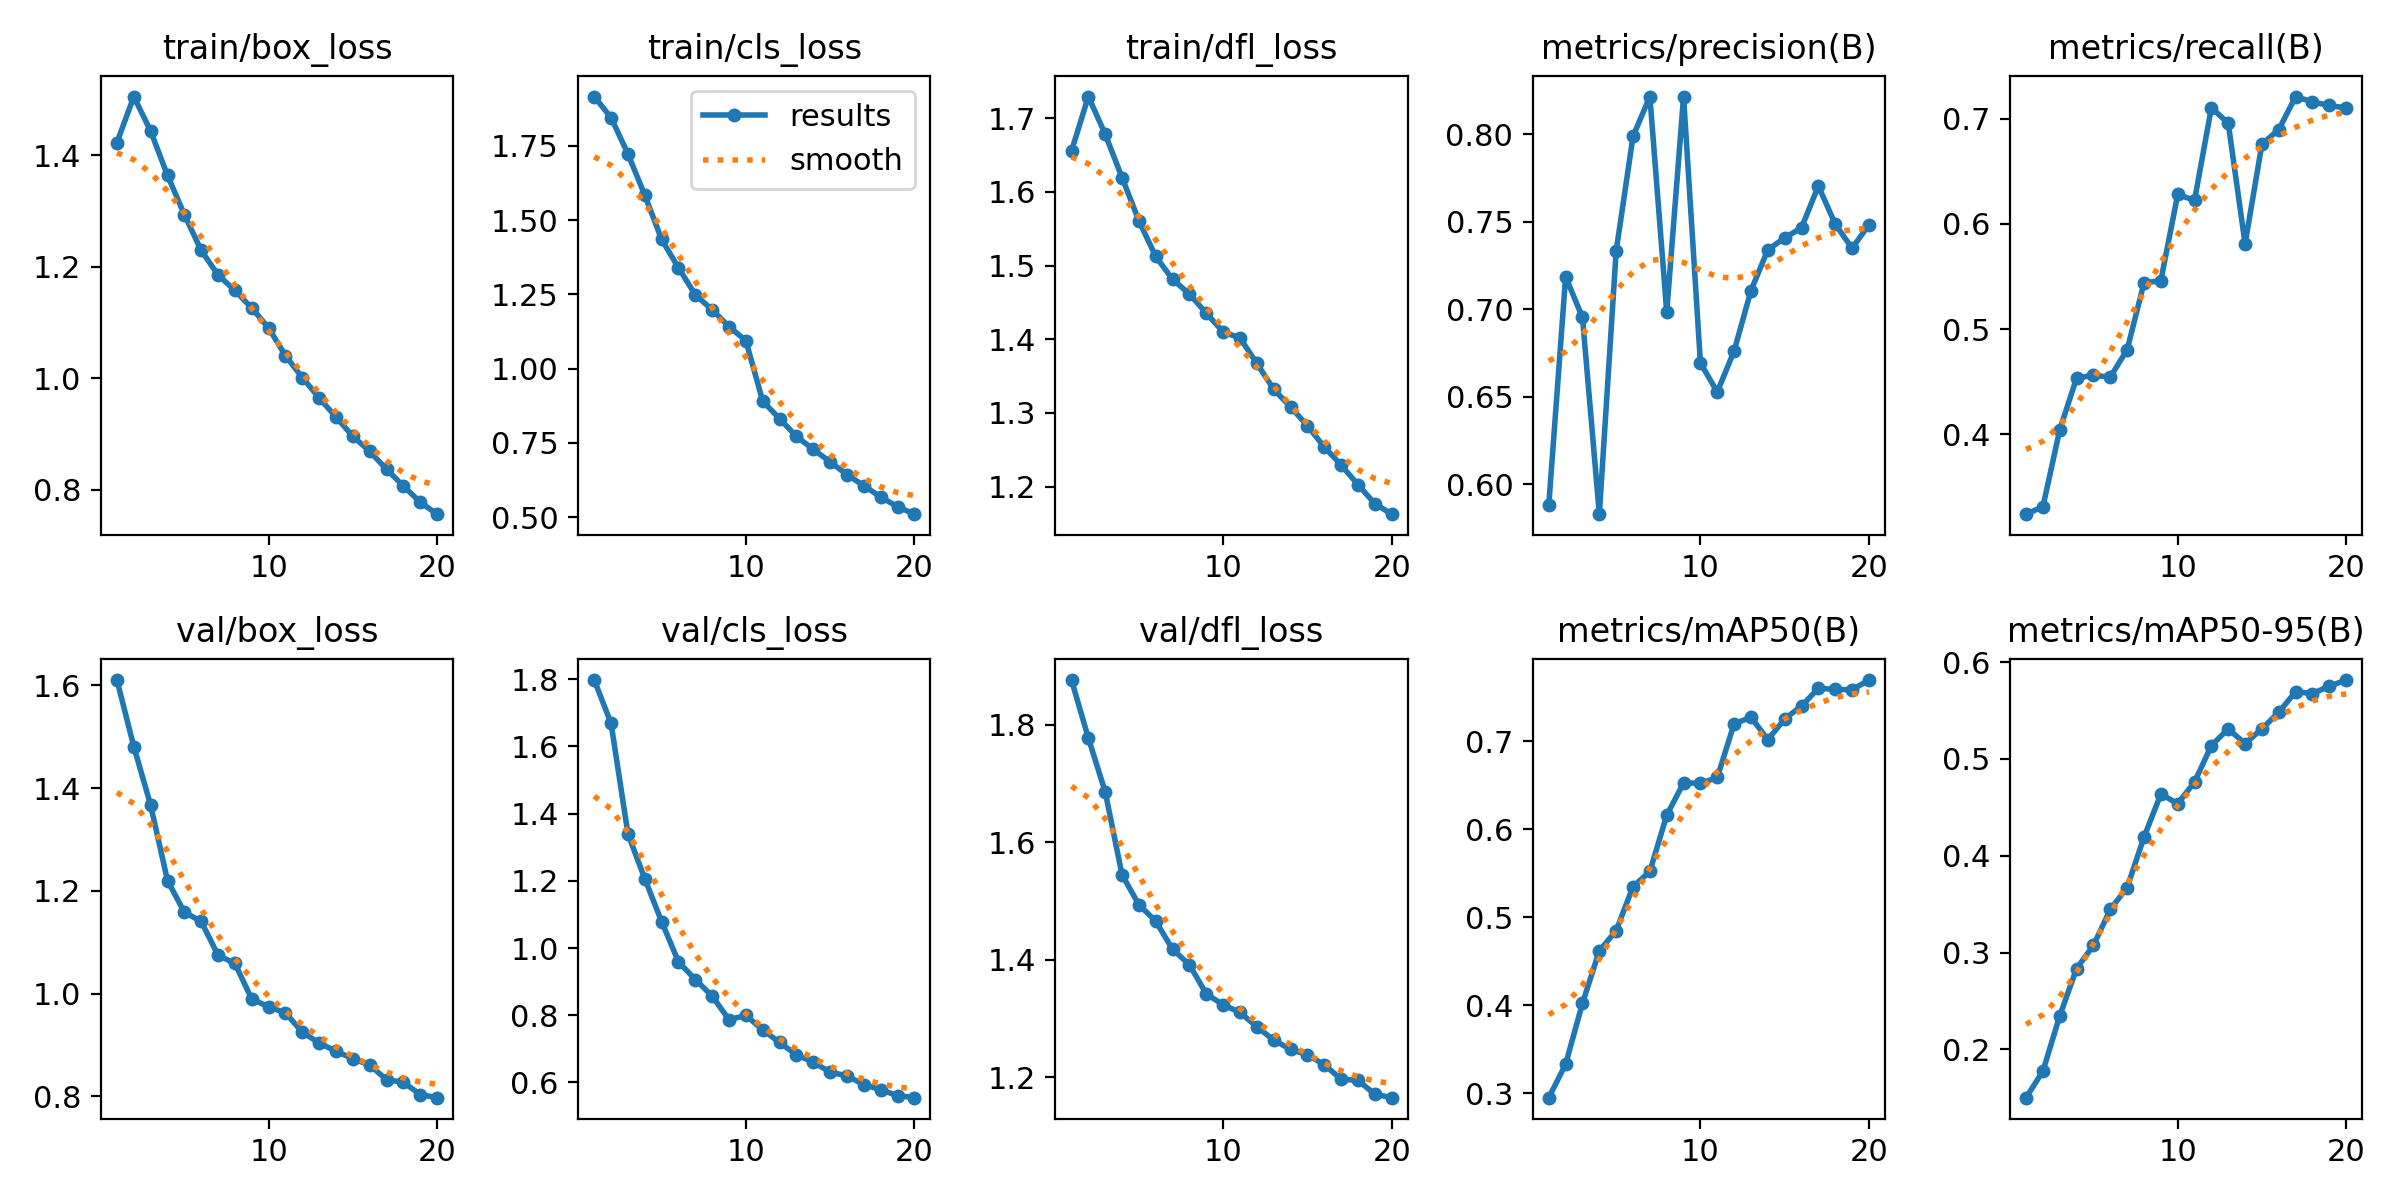

In [15]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

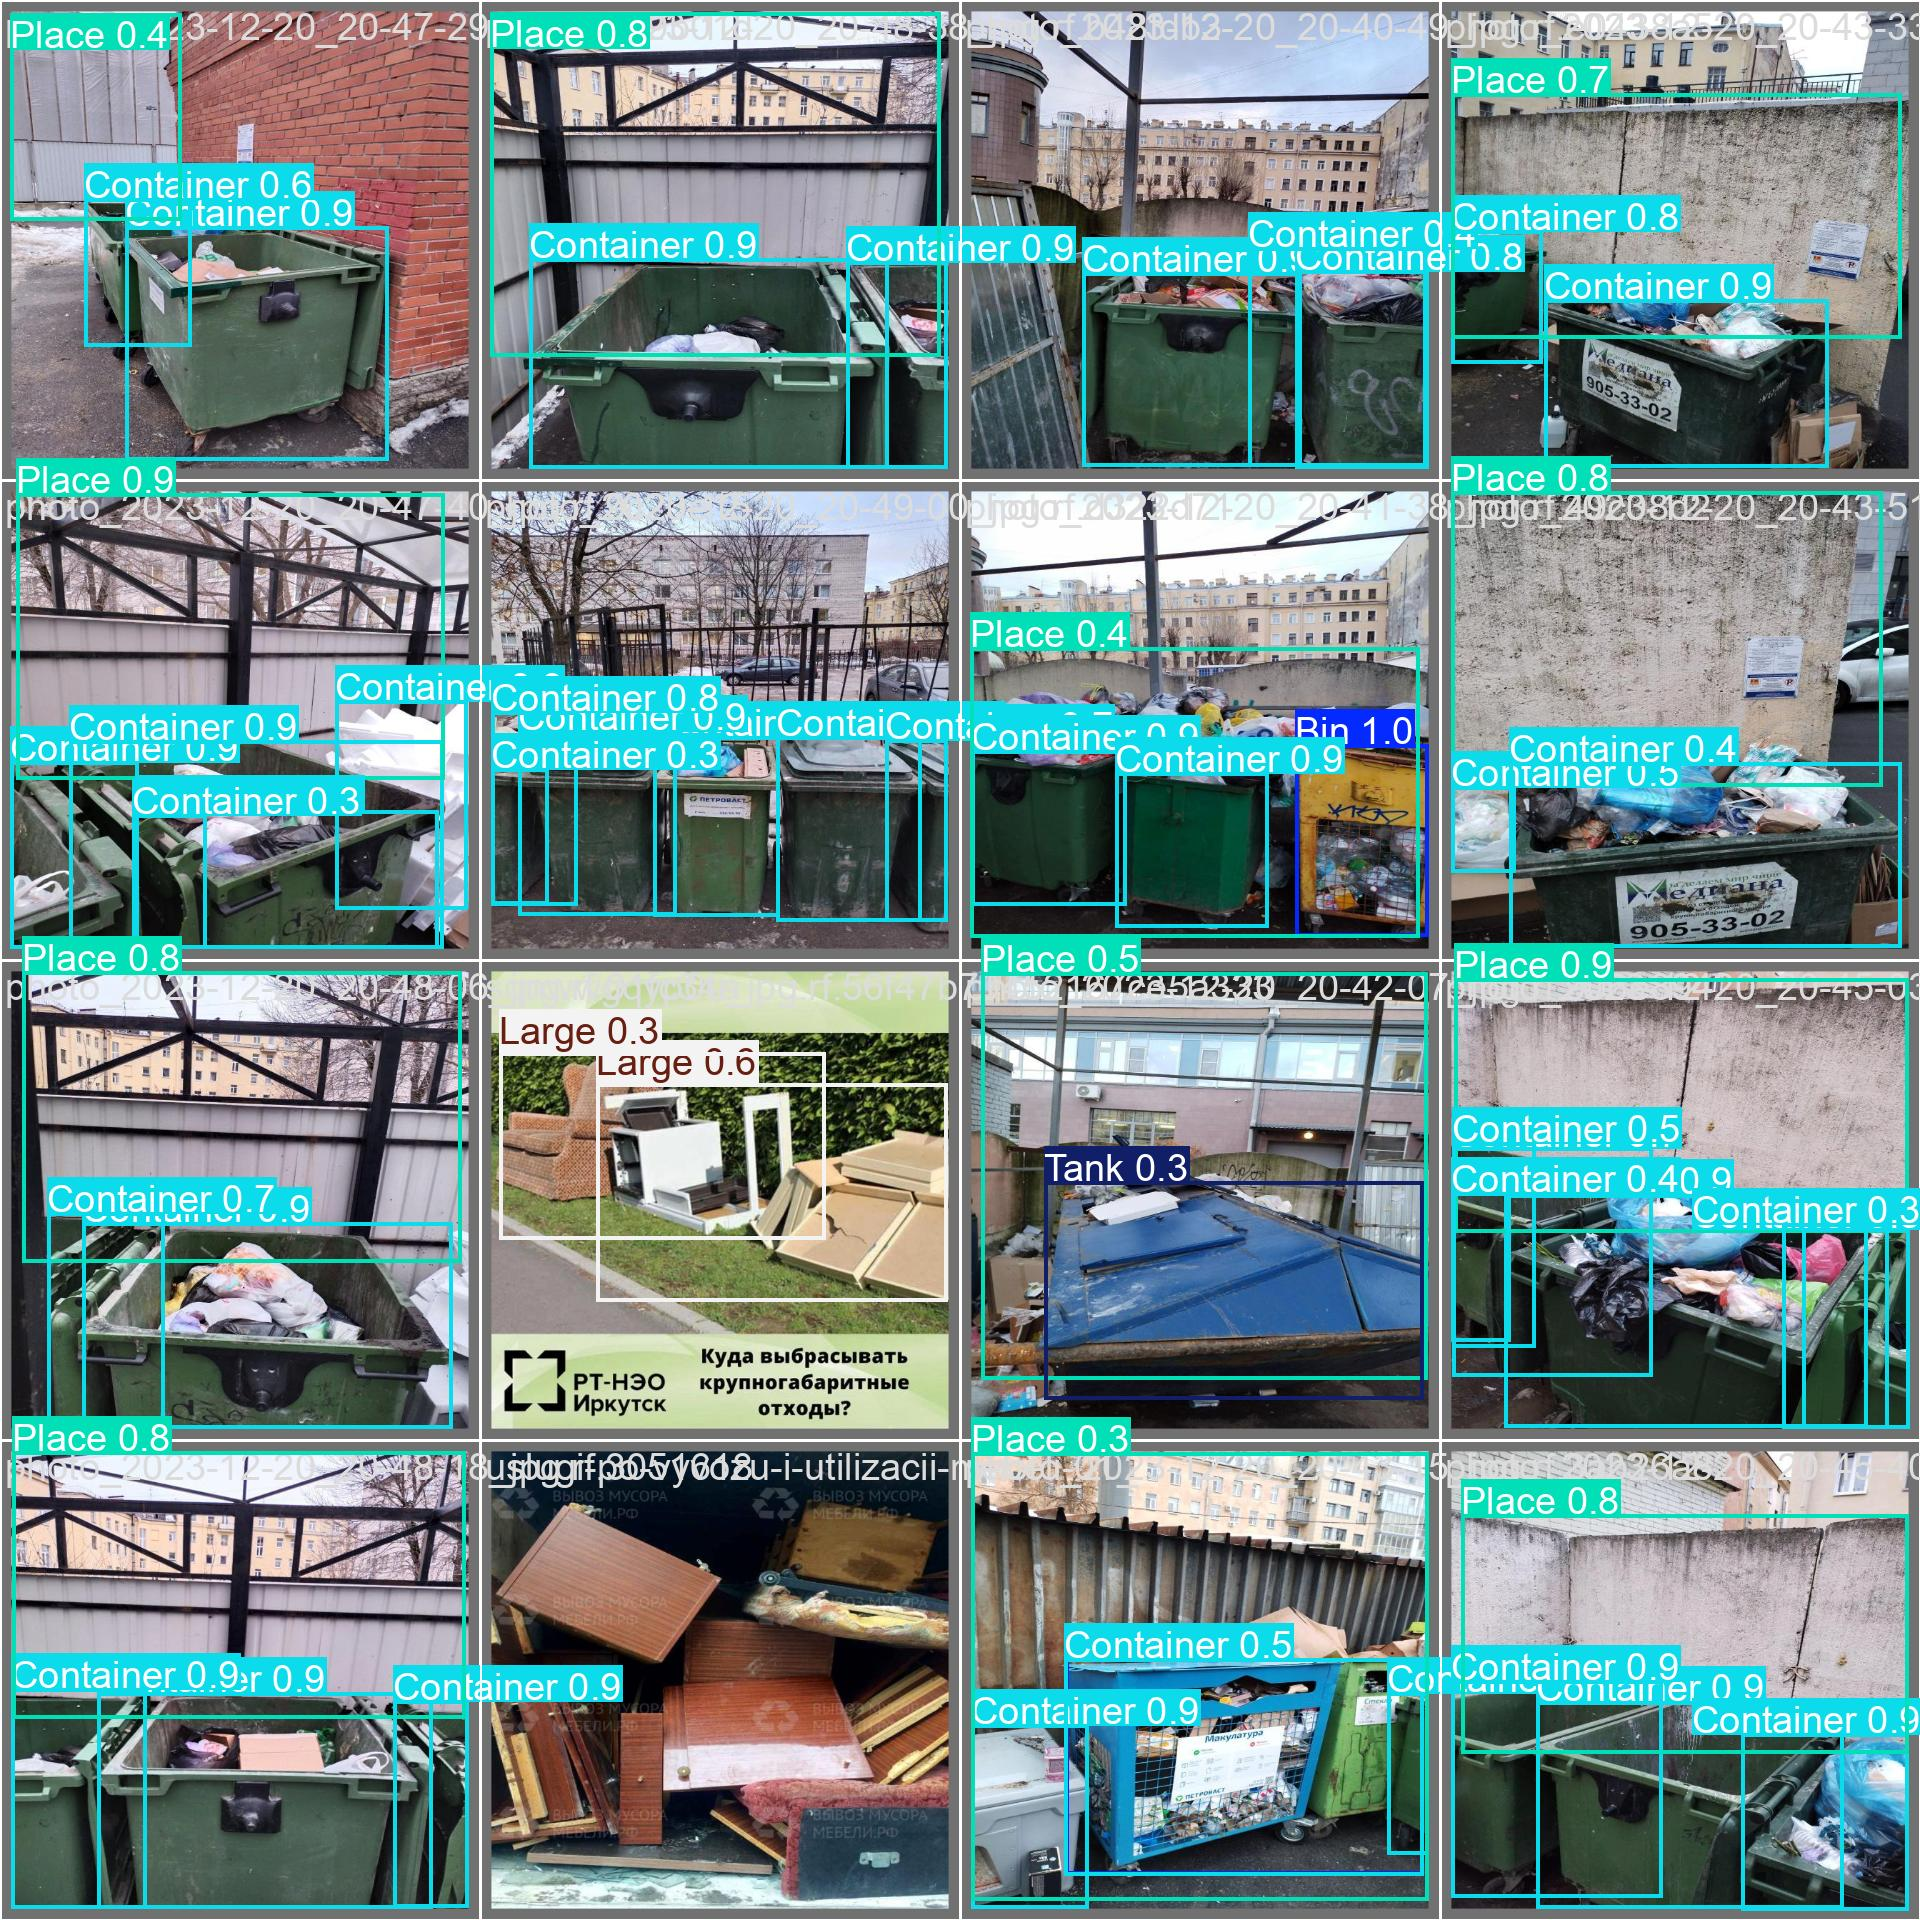

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Валидация предобученной модели

In [21]:
!yolo task=detect mode=val model=yolo11m.pt data={dataset.location}/data.yaml

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs
val: Scanning /content/tula-2/valid/labels.cache... 1568 images, 3 backgrounds, 0 corrupt: 100% 1568/1568 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 98/98 [00:47<00:00,  2.04it/s]
                   all       1568       3445     0.0133     0.0335    0.00757    0.00487
                person          9         12          0          0          0          0
               bicycle        267        691    0.00156     0.0101    0.00079   0.000337
                   car         14         15          0          0          0          0
            motorcycle        354        358    0.00223     0.0307    0.00115   0.000529
              airplane         57         58     0.0276      0.103     0.0166      0.015
                   bus        676        842    0.

## Валидация fine-tuned модели

In [20]:
!yolo task=detect mode=val model={HOME}/runs/detect/train2/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,035,429 parameters, 0 gradients, 67.7 GFLOPs
val: Scanning /content/tula-2/valid/labels.cache... 1568 images, 3 backgrounds, 0 corrupt: 100% 1568/1568 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 98/98 [00:46<00:00,  2.09it/s]
                   all       1568       3445      0.748       0.71      0.769      0.582
                   Bin          9         12      0.613      0.583      0.593      0.422
             Container        267        691      0.867      0.839       0.91      0.674
                 Large         14         15      0.314      0.267      0.245      0.132
                 Place        354        358      0.861      0.827      0.916      0.659
                  Tank         57         58      0.749      0.707      0.839       0.67
               garbage        676        842      

## Измерение инференса моделей

In [22]:
!yolo task=detect mode=predict model=yolo11m.pt conf=0.25 source={dataset.location}/test/images

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,091,712 parameters, 0 gradients, 68.0 GFLOPs

image 1/740 /content/tula-2/test/images/-1-_jpg.rf.3bd14c83ffe8af0618a37fe8845e931f.jpg: 640x640 (no detections), 37.1ms
image 2/740 /content/tula-2/test/images/-1-_jpg.rf.95078508ee7c95270fe6d37b8a1706c9.jpg: 640x640 (no detections), 37.1ms
image 3/740 /content/tula-2/test/images/-_jpg.rf.1b446caee1ba8f34eb1f61d30aba78a2.jpg: 640x640 (no detections), 37.1ms
image 4/740 /content/tula-2/test/images/-_jpg.rf.b09b6bf097fda566dfd43fd550c73601.jpg: 640x640 (no detections), 37.1ms
image 5/740 /content/tula-2/test/images/000033_jpg.rf.3bdab75a35cda10dd58465dc58755ea9.jpg: 640x640 1 car, 1 teddy bear, 29.5ms
image 6/740 /content/tula-2/test/images/000044_jpg.rf.96ca60feba9d47db2d1005557d82b83f.jpg: 640x640 (no detections), 27.6ms
image 7/740 /content/tula-2/test/images/000045_jpg.rf.6e5de17d7dc7dce2143208e2a730af89.jpg: 640x640 

In [23]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11m summary (fused): 303 layers, 20,035,429 parameters, 0 gradients, 67.7 GFLOPs

image 1/740 /content/tula-2/test/images/-1-_jpg.rf.3bd14c83ffe8af0618a37fe8845e931f.jpg: 640x640 (no detections), 36.9ms
image 2/740 /content/tula-2/test/images/-1-_jpg.rf.95078508ee7c95270fe6d37b8a1706c9.jpg: 640x640 (no detections), 36.8ms
image 3/740 /content/tula-2/test/images/-_jpg.rf.1b446caee1ba8f34eb1f61d30aba78a2.jpg: 640x640 1 Large, 36.8ms
image 4/740 /content/tula-2/test/images/-_jpg.rf.b09b6bf097fda566dfd43fd550c73601.jpg: 640x640 1 Large, 23.7ms
image 5/740 /content/tula-2/test/images/000033_jpg.rf.3bdab75a35cda10dd58465dc58755ea9.jpg: 640x640 1 garbage, 2 overflows, 23.6ms
image 6/740 /content/tula-2/test/images/000044_jpg.rf.96ca60feba9d47db2d1005557d82b83f.jpg: 640x640 2 overflows, 23.6ms
image 7/740 /content/tula-2/test/images/000045_jpg.rf.6e5de17d7dc7dce2143208e2a730af89.jpg: 640x640 1 garbage, 23.6ms

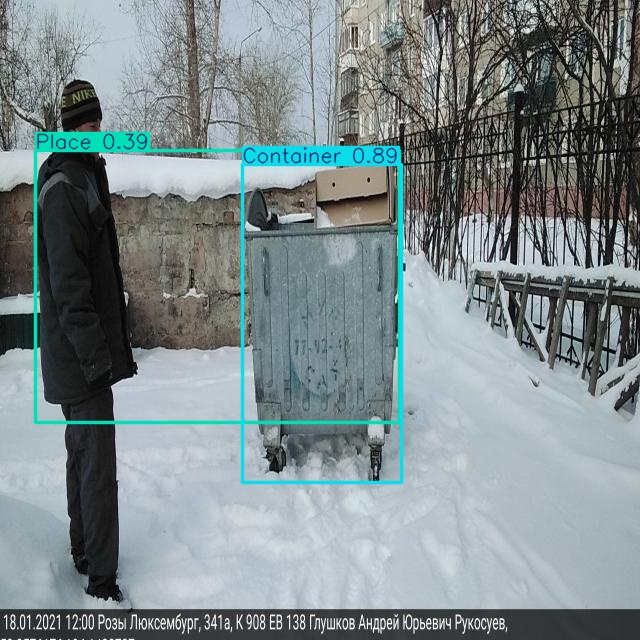

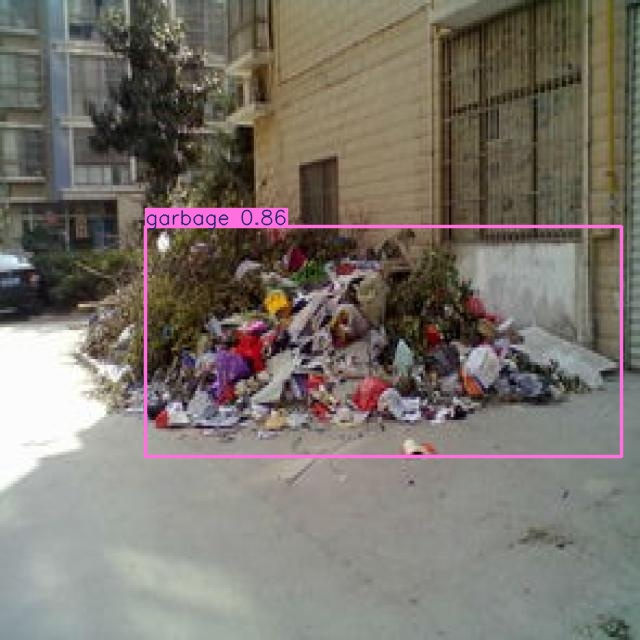

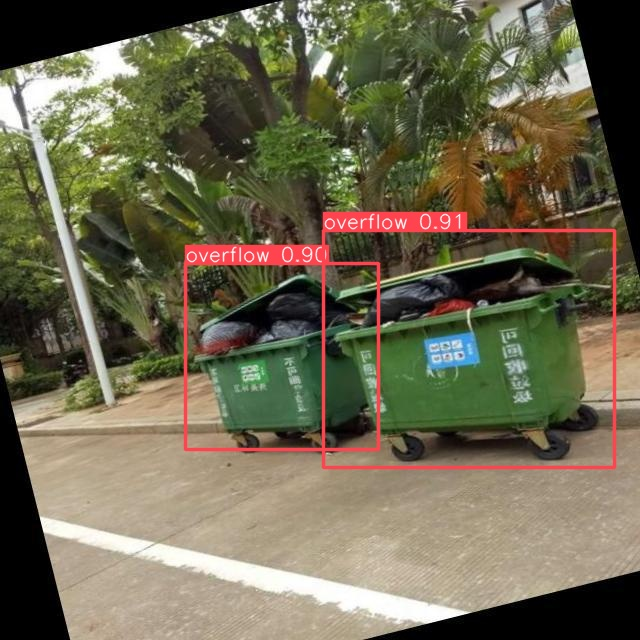

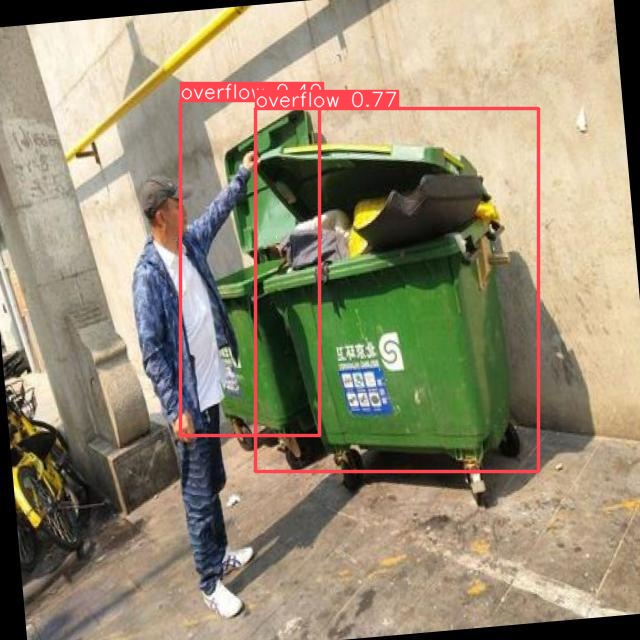

In [25]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict2/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:4]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Экспорт модели

In [26]:
from ultralytics import YOLO
model = YOLO("/content/runs/detect/train2/weights/best.pt")
model.export(format="onnx")

Ultralytics 8.3.31 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.00GHz)
YOLO11m summary (fused): 303 layers, 20,035,429 parameters, 0 gradients, 67.7 GFLOPs

PyTorch: starting from '/content/runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 11, 8400) (38.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 282.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.8/141.8 kB 292.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 175.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 231.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 265.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 21.2s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun c

'/content/runs/detect/train2/weights/best.onnx'